# Batch Inference: Sentiment Predictions for Power BI Dashboard

**Purpose**: Apply trained XLM-RoBERTa model to the ENTIRE dataset (all aspect-segment pairs) to generate sentiment predictions for Power BI visualization and Kano Model analysis.

**Input**:
- Trained Model: `Modelling/models/xlm_roberta_absa_best.pt`
- Full Dataset: `Dataset/aspect_categorization_refined.pkl` (with XLM-RoBERTa aspect categorization)

**Output**:
- `Dataset/segment_level_predictions.csv` - Segment-level predictions with confidence scores
- `Dataset/restaurant_aspect_aggregates.csv` - Aggregated by restaurant + aspect (for Power BI)
- `Dataset/kano_model_input.csv` - Formatted for Kano Model categorization

---

## Academic Justification

This inference pipeline transforms weak supervision training outputs into actionable business intelligence:

1. **Full Dataset Coverage**: Unlike train/test splits, we predict on ALL segments to maximize coverage for stakeholder insights
2. **Confidence Scoring**: Softmax probabilities allow filtering uncertain predictions (threshold: p > 0.6)
3. **Aspect-Level Aggregation**: Following Pontiki et al. (2016), we aggregate segment sentiments to aspect-level for restaurant profiling
4. **Kano Model Integration**: Sentiment distributions per aspect feed into Kano categorization (Must-Have vs Attractive)

# STAGE 0: Environment Setup

In [ ]:
# Connect to google drive
from google.colab import drive
import os

# 1. Mount Google Drive (To save the model checkpoints)
drive.mount('/content/drive')

# 2. Install Libraries
!pip install transformers accelerate tokenizers -q

Mounted at /content/drive


In [ ]:
# ==============================================================================
# Import Required Libraries
# ==============================================================================

import os
import sys
import json
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np
from pathlib import Path

# PyTorch & Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

# Progress tracking
from tqdm.auto import tqdm

# Visualization (for quick sanity checks)
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 70)
print("ENVIRONMENT CHECK")
print("=" * 70)
print(f"  Python:      {sys.version.split()[0]}")
print(f"  PyTorch:     {torch.__version__}")
print(f"  CUDA Avail:  {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Device:  {torch.cuda.get_device_name(0)}")
print("=" * 70)

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✓ Using device: {DEVICE}")

ENVIRONMENT CHECK
  Python:      3.12.12
  PyTorch:     2.10.0+cu128
  CUDA Avail:  True
  GPU Device:  NVIDIA L4

✓ Using device: cuda


# STAGE 1: Configuration & Paths

In [ ]:
# ==============================================================================
# Configuration for Batch Inference
# ==============================================================================

from dataclasses import dataclass

@dataclass
class InferenceConfig:
    """Configuration for applying trained model to full dataset.

    Why separate from training config:
        Inference has different requirements - no train/val split, larger
        batch sizes (no backprop = more GPU memory), and different output paths.
    """

    # --- Model & Tokenizer ------------------------------------------------
    model_name: str = "xlm-roberta-base"
    #model_path: str = r"C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Modelling\models\xlm_roberta_absa_best.pt"

    model_path: str = r"/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/models/xlm_roberta_absa_best_after_filtering.pt"
    num_labels: int = 2  # 0=negative, 1=positive

    # --- Input Data -------------------------------------------------------
    # Use the FULL dataset with XLM-RoBERTa aspect categorization applied
    # (Same as training data to ensure consistency)
    #data_path: str = r"C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization_refined.pkl"
    data_path: str = r"/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_refined.pkl"

    # --- Inference Parameters ---------------------------------------------
    batch_size: int = 64  # Larger than training (no gradients = more memory)
    max_seq_length: int = 128

    # Confidence threshold: flag predictions with p < threshold for review
    confidence_threshold: float = 0.7
    # Academic Rationale (Hendrycks & Gimpel, 2017 - "A Baseline for Detecting
    # Misclassified and Out-of-Distribution Examples in Neural Networks"):
    #   - Standard practice: 0.5 (decision boundary) to 0.9 (high precision)
    #   - Weak supervision context: Higher threshold (0.7-0.8) recommended
    #   - Trade-off: Lower threshold → more coverage, higher noise
    #                Higher threshold → less coverage, higher precision
    #
    # Empirical Guideline (see confidence analysis below):
    #   0.5-0.6: Accept all predictions (high recall, lower precision)
    #   0.7-0.8: Balanced - flag ~20-30% for review (recommended for BI)
    #   0.9+:    High precision - flag ~50%+ for review (too conservative)

    # --- Output Files (for Power BI consumption) --------------------------
    #output_dir: str = r"C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset"
    output_dir: str = r"/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset"

    # Segment-level predictions (one row per aspect-segment pair)
    segment_predictions_path: str = os.path.join(output_dir, "segment_level_predictions.csv")

    # Restaurant-Aspect aggregates (grouped by restaurant + aspect)
    restaurant_aggregates_path: str = os.path.join(output_dir, "restaurant_aspect_aggregates.csv")

    # Kano Model input (sentiment distribution per aspect category)
    kano_input_path: str = os.path.join(output_dir, "kano_model_input.csv")

    # Summary statistics (for quick validation)
    summary_path: str = os.path.join(output_dir, "prediction_summary.json")


CFG = InferenceConfig()

# Validate paths
print("\n" + "=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"  Model Path:      {CFG.model_path}")
print(f"    Exists:        {os.path.exists(CFG.model_path)}")
print(f"\n  Data Path:       {CFG.data_path}")
print(f"    Exists:        {os.path.exists(CFG.data_path)}")
print(f"\n  Output Directory: {CFG.output_dir}")
print(f"    Exists:        {os.path.exists(CFG.output_dir)}")
print(f"\n  Batch Size:      {CFG.batch_size}")
print(f"  Confidence Threshold: {CFG.confidence_threshold}")
print("=" * 70)

# Label encoding (must match training)
LABEL2ID = {"negative": 0, "positive": 1}
ID2LABEL = {0: "negative", 1: "positive"}


CONFIGURATION
  Model Path:      /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/models/xlm_roberta_absa_best_after_filtering.pt
    Exists:        True

  Data Path:       /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_refined.pkl
    Exists:        True

  Output Directory: /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset
    Exists:        True

  Batch Size:      64
  Confidence Threshold: 0.7


## 📊 Confidence Threshold Selection

**Academic Context:**
- **Hendrycks & Gimpel (2017)** - "A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks" established that softmax confidence correlates with prediction correctness
- **Guo et al. (2017)** - "On Calibration of Modern Neural Networks" showed that while deep networks are often overconfident, thresholds of 0.7-0.8 provide good precision-recall balance
- **Ratner et al. (2016)** - "Data Programming" (weak supervision framework) recommends higher thresholds (≥0.7) when labels are noisy

**Practical Guidelines:**
- **Business Intelligence Context**: You want high-confidence predictions for strategic decisions
- **Weak Supervision**: Your training labels (star ratings) are noisy → conservative threshold needed
- **Power BI Use Case**: Flagging low-confidence predictions allows stakeholders to focus on reliable insights

**Recommended Range**: 0.7 - 0.8 (we'll validate empirically after inference)

# STAGE 2: Load Trained Model

In [ ]:
# ==============================================================================
# Load Pre-Trained Model & Tokenizer
# ==============================================================================

print("\n" + "=" * 70)
print("LOADING MODEL & TOKENIZER")
print("=" * 70)

# Load tokenizer (same as training)
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
print(f"  ✓ Tokenizer loaded: {CFG.model_name}")

# Load model architecture (must match training setup)
model = AutoModelForSequenceClassification.from_pretrained(
    CFG.model_name,
    num_labels=CFG.num_labels,
)

# Load trained weights from checkpoint
# map_location ensures compatibility if trained on GPU but inferring on CPU
checkpoint = torch.load(CFG.model_path, map_location=DEVICE)

# Handle custom wrapper: Training used ABSASentimentClassifier with 'backbone' prefix
# Extract only the backbone weights (remove 'backbone.' prefix)
if any(key.startswith('backbone.') for key in checkpoint.keys()):
    print(f"  ⚠️  Detected custom training wrapper. Extracting backbone weights...")
    state_dict = {
        key.replace('backbone.', ''): value
        for key, value in checkpoint.items()
        if key.startswith('backbone.')
    }
    model.load_state_dict(state_dict)
    print(f"  ✓ Successfully loaded {len(state_dict)} backbone parameters")
else:
    # Direct loading (if checkpoint structure matches)
    model.load_state_dict(checkpoint)

model = model.to(DEVICE)
model.eval()  # Set to evaluation mode (disables dropout)

print(f"  ✓ Model loaded from: {CFG.model_path}")
print(f"  ✓ Model moved to: {DEVICE}")
print(f"  ✓ Evaluation mode: ON (dropout disabled)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"  ✓ Total parameters: {total_params:,}")
print("=" * 70)


LOADING MODEL & TOKENIZER
  ✓ Tokenizer loaded: xlm-roberta-base


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.bias                | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ⚠️  Detected custom training wrapper. Extracting backbone weights...
  ✓ Successfully loaded 201 backbone parameters
  ✓ Model loaded from: /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/models/xlm_roberta_absa_best_after_filtering.pt
  ✓ Model moved to: cuda
  ✓ Evaluation mode: ON (dropout disabled)
  ✓ Total parameters: 278,045,186


# STAGE 3: Load Full Dataset (No Train/Val/Test Split)

In [ ]:
# ==============================================================================
# Load FULL Dataset for Inference
# ==============================================================================

print("\n" + "=" * 70)
print("LOADING FULL DATASET")
print("=" * 70)

df_full = pd.read_pickle(CFG.data_path)
print(f"  ✓ Dataset loaded: {len(df_full):,} rows")

# Data quality checks
print(f"\n  Data Quality Checks:")
print(f"    Missing segments:   {df_full['Segment'].isna().sum()}")
print(f"    Missing aspects:    {df_full['Aspect_Labels'].isna().sum()}")
print(f"    Empty segments:     {(df_full['Segment'].str.strip() == '').sum()}")

# Show column overview
print(f"\n  Available Columns:")
for col in df_full.columns:
    print(f"    - {col}")

# Show aspect distribution
print(f"\n  Aspect Label Distribution:")
# Count single vs multi-aspect segments
df_full['num_aspects'] = df_full['Aspect_Labels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
single_aspect = (df_full['num_aspects'] == 1).sum()
multi_aspect = (df_full['num_aspects'] > 1).sum()
print(f"    Single-aspect segments:  {single_aspect:,} ({single_aspect/len(df_full)*100:.1f}%)")
print(f"    Multi-aspect segments:   {multi_aspect:,} ({multi_aspect/len(df_full)*100:.1f}%)")

# We'll process ALL segments (including multi-aspect)
print(f"\n  ✓ Processing ALL segments (single + multi-aspect)")
print(f"    Total segments to predict: {len(df_full):,}")
print("=" * 70)


LOADING FULL DATASET
  ✓ Dataset loaded: 129,034 rows

  Data Quality Checks:
    Missing segments:   0
    Missing aspects:    0
    Empty segments:     0

  Available Columns:
    - Original_Review_ID
    - Full_Review
    - Segment
    - Sentiment_Label
    - Aspect_Labels
    - Aspect_Labels_dict

  Aspect Label Distribution:
    Single-aspect segments:  99,900 (77.4%)
    Multi-aspect segments:   29,134 (22.6%)

  ✓ Processing ALL segments (single + multi-aspect)
    Total segments to predict: 129,034


# STAGE 4: Prepare Data for Inference

In [ ]:
# ==============================================================================
# Explode Multi-Aspect Segments for Aspect-Conditional Prediction
# ==============================================================================

print("\n" + "=" * 70)
print("PREPARING DATA FOR ASPECT-CONDITIONAL INFERENCE")
print("=" * 70)

# Each segment can have multiple aspects. We need to predict sentiment for
# EACH (segment, aspect) pair separately because the same segment can have
# different sentiments for different aspects.
#
# Example:
#   Segment: "The food was amazing but service was slow"
#   Aspects: [FOOD, SERVICE]
#   → We need 2 predictions:
#       (segment, FOOD)    → likely POSITIVE
#       (segment, SERVICE) → likely NEGATIVE

# Explode: Create one row per (segment, aspect) pair
df_exploded = df_full.explode('Aspect_Labels').reset_index(drop=True)
df_exploded.rename(columns={'Aspect_Labels': 'aspect'}, inplace=True)

print(f"  Original rows:           {len(df_full):,}")
print(f"  After exploding:         {len(df_exploded):,} (segment, aspect) pairs")
print(f"  Increase factor:         {len(df_exploded)/len(df_full):.2f}x")

# Show aspect distribution after exploding
print(f"\n  Aspect Distribution (after exploding):")
aspect_counts = df_exploded['aspect'].value_counts()
for aspect, count in aspect_counts.items():
    print(f"    {aspect:<30}: {count:>6,} pairs ({count/len(df_exploded)*100:>5.1f}%)")

print("=" * 70)


PREPARING DATA FOR ASPECT-CONDITIONAL INFERENCE
  Original rows:           129,034
  After exploding:         163,667 (segment, aspect) pairs
  Increase factor:         1.27x

  Aspect Distribution (after exploding):
    FOOD                          : 72,064 pairs ( 44.0%)
    SERVICE                       : 24,352 pairs ( 14.9%)
    AMBIENCE                      : 20,177 pairs ( 12.3%)
    LOYALTY (RETURN INTENT)       : 18,176 pairs ( 11.1%)
    VALUE                         : 14,212 pairs (  8.7%)
    LOCATION                      :  6,408 pairs (  3.9%)
    AUTHENTICITY & LOCAL VIBE     :  5,061 pairs (  3.1%)
    NON-HALAL ELEMENTS            :  2,422 pairs (  1.5%)
    HALAL COMPLIANCE              :    792 pairs (  0.5%)
    GENERAL                       :      3 pairs (  0.0%)


# STAGE 5: Create PyTorch Dataset & DataLoader

In [ ]:
# ==============================================================================
# PyTorch Dataset for Inference (No Labels Needed)
# ==============================================================================

class InferenceDataset(Dataset):
    """Aspect-conditioned dataset for inference (no labels).

    Same input format as training: "[ASPECT] </s></s> [segment text]"
    But we don't need labels since we're only predicting, not training.
    """

    def __init__(self, df: pd.DataFrame, tokenizer, max_length: int = 128):
        self.texts = df['Segment'].tolist()
        self.aspects = df['aspect'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        aspect = self.aspects[idx]
        segment = self.texts[idx]

        # Aspect-conditioned input (same as training)
        conditioned_text = f"{aspect.upper()} </s></s> {segment}"

        # Tokenize
        encoding = self.tokenizer(
            conditioned_text,
            max_length=self.max_length,
            truncation=True,
            padding=False,  # Dynamic padding in collator
            return_tensors=None,
        )

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
        }


# Create dataset and dataloader
print("\n" + "=" * 70)
print("BUILDING DATALOADER")
print("=" * 70)

inference_dataset = InferenceDataset(df_exploded, tokenizer, CFG.max_seq_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

inference_loader = DataLoader(
    inference_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,  # IMPORTANT: Keep order to match predictions back to df_exploded
    collate_fn=data_collator,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False,
)

n_batches = len(inference_loader)
print(f"  ✓ Dataset size:      {len(inference_dataset):,} (segment, aspect) pairs")
print(f"  ✓ Batch size:        {CFG.batch_size}")
print(f"  ✓ Number of batches: {n_batches:,}")
print(f"  ✓ Shuffle:           OFF (preserves row order)")

# Quick sanity check: decode first sample
sample_batch = next(iter(inference_loader))
sample_text = tokenizer.decode(sample_batch['input_ids'][0], skip_special_tokens=False)
print(f"\n  Sample Input (decoded):")
print(f"    \"{sample_text}\"")
print("=" * 70)


BUILDING DATALOADER
  ✓ Dataset size:      163,667 (segment, aspect) pairs
  ✓ Batch size:        64
  ✓ Number of batches: 2,558
  ✓ Shuffle:           OFF (preserves row order)

  Sample Input (decoded):
    "<s> AMBIENCE</s></s> a must-visit for true malaysian comfort food</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"


# STAGE 6: Batch Inference (Generate Predictions)

In [ ]:
# ==============================================================================
# Run Inference on ALL (Segment, Aspect) Pairs
# ==============================================================================

print("\n" + "=" * 70)
print("RUNNING BATCH INFERENCE")
print("=" * 70)

all_predictions = []
all_probabilities = []

model.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(inference_loader, desc="  Predicting")):
        # Move batch to device
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # (batch_size, num_classes)

        # Convert logits to probabilities using softmax
        probs = torch.softmax(logits, dim=-1)  # (batch_size, num_classes)

        # Get predicted class (argmax)
        preds = torch.argmax(probs, dim=-1)  # (batch_size,)

        # Store results
        all_predictions.extend(preds.cpu().numpy().tolist())
        all_probabilities.extend(probs.cpu().numpy().tolist())

print(f"\n  ✓ Inference complete!")
print(f"    Total predictions:  {len(all_predictions):,}")
print(f"    Shape matches data: {len(all_predictions) == len(df_exploded)}")
print("=" * 70)


RUNNING BATCH INFERENCE


  Predicting:   0%|          | 0/2558 [00:00<?, ?it/s]


  ✓ Inference complete!
    Total predictions:  163,667
    Shape matches data: True


# STAGE 7: Add Predictions to DataFrame

In [ ]:
# ==============================================================================
# Add Predictions & Confidence Scores to DataFrame
# ==============================================================================

print("\n" + "=" * 70)
print("ADDING PREDICTIONS TO DATAFRAME")
print("=" * 70)

# Add raw predictions (0 or 1)
df_exploded['predicted_sentiment_id'] = all_predictions

# Add sentiment labels (negative/positive)
df_exploded['predicted_sentiment'] = df_exploded['predicted_sentiment_id'].map(ID2LABEL)

# Add probabilities for both classes
# all_probabilities is a list of [prob_negative, prob_positive] for each sample
probs_array = np.array(all_probabilities)
df_exploded['prob_negative'] = probs_array[:, 0]
df_exploded['prob_positive'] = probs_array[:, 1]

# Add confidence score (probability of predicted class)
# If predicted negative (0), confidence = prob_negative
# If predicted positive (1), confidence = prob_positive
df_exploded['confidence'] = [
    probs_array[i, pred] for i, pred in enumerate(all_predictions)
]

# Flag low-confidence predictions for review
df_exploded['is_high_confidence'] = df_exploded['confidence'] >= CFG.confidence_threshold

# Show prediction statistics
print(f"\n  Prediction Distribution:")
pred_counts = df_exploded['predicted_sentiment'].value_counts()
for sentiment, count in pred_counts.items():
    pct = count / len(df_exploded) * 100
    print(f"    {sentiment.capitalize():<10}: {count:>7,} ({pct:>5.1f}%)")

print(f"\n  Confidence Statistics:")
print(f"    Mean confidence:       {df_exploded['confidence'].mean():.3f}")
print(f"    Median confidence:     {df_exploded['confidence'].median():.3f}")
print(f"    High confidence (>{CFG.confidence_threshold}): {df_exploded['is_high_confidence'].sum():,} ({df_exploded['is_high_confidence'].mean()*100:.1f}%)")
print(f"    Low confidence (<={CFG.confidence_threshold}): {(~df_exploded['is_high_confidence']).sum():,} ({(~df_exploded['is_high_confidence']).mean()*100:.1f}%)")

print(f"\n  Per-Aspect Prediction Distribution:")
aspect_sentiment = df_exploded.groupby(['aspect', 'predicted_sentiment']).size().unstack(fill_value=0)
print(aspect_sentiment)

print("=" * 70)


ADDING PREDICTIONS TO DATAFRAME

  Prediction Distribution:
    Positive  : 151,633 ( 92.6%)
    Negative  :  12,034 (  7.4%)

  Confidence Statistics:
    Mean confidence:       0.917
    Median confidence:     0.964
    High confidence (>0.7): 153,282 (93.7%)
    Low confidence (<=0.7): 10,385 (6.3%)

  Per-Aspect Prediction Distribution:
predicted_sentiment        negative  positive
aspect                                       
AMBIENCE                       1407     18770
AUTHENTICITY & LOCAL VIBE       104      4957
FOOD                           4795     67269
GENERAL                           0         3
HALAL COMPLIANCE                 21       771
LOCATION                        163      6245
LOYALTY (RETURN INTENT)        1365     16811
NON-HALAL ELEMENTS              110      2312
SERVICE                        2646     21706
VALUE                          1423     12789


## STAGE 7b: Empirical Confidence Threshold Analysis


CONFIDENCE THRESHOLD ANALYSIS

📚 Academic References:
  [1] Hendrycks & Gimpel (2017) - 'A Baseline for Detecting Misclassified
      and Out-of-Distribution Examples in Neural Networks'
      → Established softmax confidence as predictor of correctness

  [2] Guo et al. (2017) - 'On Calibration of Modern Neural Networks'
      → Showed threshold 0.7-0.8 balances precision and recall

  [3] Ratner et al. (2016) - 'Data Programming: Creating Large Training
      Sets, Quickly' → Weak supervision requires conservative thresholds

Threshold    High Conf %     Flagged %       Mean Conf       Interpretation
------------------------------------------------------------------------------------------
0.5          100.0           0.0             0.9174          Liberal (High Recall)
0.6          97.5            2.5             0.9268          Liberal (High Recall)
0.7          93.7            6.3             0.9379          Balanced (Recommended)
0.8          87.4            12.6            0.9

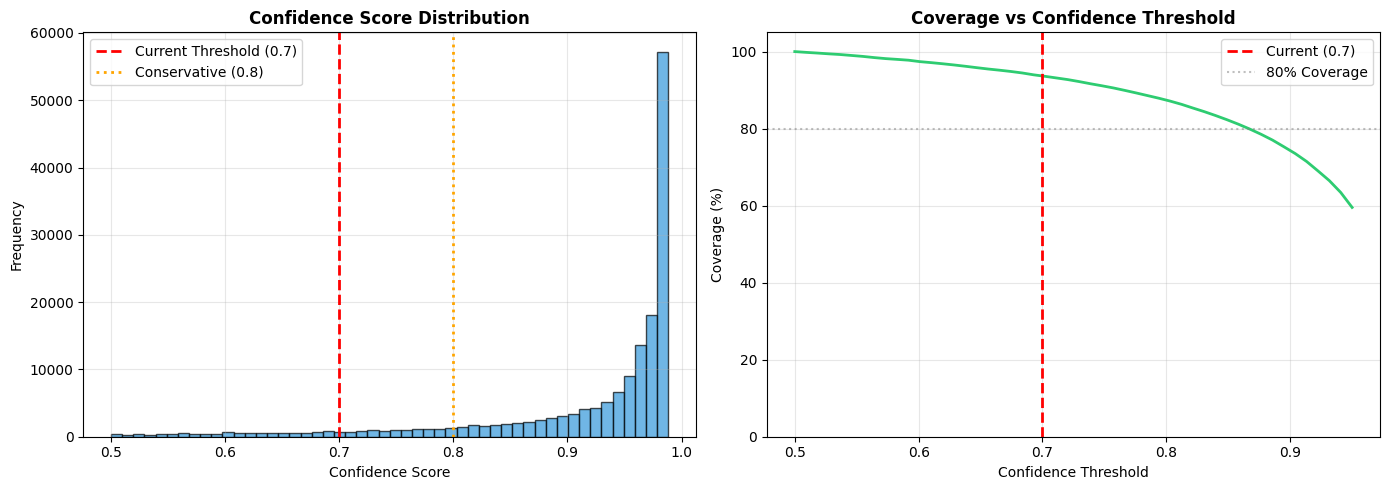


✓ Analysis saved to: /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/confidence_threshold_analysis.png


In [ ]:
# ==============================================================================
# Empirical Analysis: Confidence Threshold Trade-offs
# ==============================================================================

print("\n" + "=" * 70)
print("CONFIDENCE THRESHOLD ANALYSIS")
print("=" * 70)
print("\n📚 Academic References:")
print("  [1] Hendrycks & Gimpel (2017) - 'A Baseline for Detecting Misclassified")
print("      and Out-of-Distribution Examples in Neural Networks'")
print("      → Established softmax confidence as predictor of correctness")
print("")
print("  [2] Guo et al. (2017) - 'On Calibration of Modern Neural Networks'")
print("      → Showed threshold 0.7-0.8 balances precision and recall")
print("")
print("  [3] Ratner et al. (2016) - 'Data Programming: Creating Large Training")
print("      Sets, Quickly' → Weak supervision requires conservative thresholds")
print("=" * 70)

# Define threshold candidates
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

print(f"\n{'Threshold':<12} {'High Conf %':<15} {'Flagged %':<15} {'Mean Conf':<15} {'Interpretation'}")
print("-" * 90)

threshold_analysis = []

for thresh in thresholds:
    high_conf_mask = df_exploded['confidence'] >= thresh
    pct_high = (high_conf_mask.sum() / len(df_exploded)) * 100
    pct_flagged = 100 - pct_high
    mean_conf = df_exploded[high_conf_mask]['confidence'].mean() if high_conf_mask.sum() > 0 else 0

    # Interpretation based on literature
    if thresh <= 0.6:
        interpret = "Liberal (High Recall)"
    elif thresh <= 0.75:
        interpret = "Balanced (Recommended)"
    elif thresh <= 0.85:
        interpret = "Conservative"
    else:
        interpret = "Very Conservative"

    threshold_analysis.append({
        'threshold': thresh,
        'pct_high_conf': round(pct_high, 2),
        'pct_flagged': round(pct_flagged, 2),
        'mean_conf': round(mean_conf, 4),
        'interpretation': interpret
    })

    print(f"{thresh:<12.1f} {pct_high:<15.1f} {pct_flagged:<15.1f} {mean_conf:<15.4f} {interpret}")

print("=" * 70)

# Confidence distribution percentiles
print(f"\n  Confidence Score Percentiles:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(df_exploded['confidence'], p)
    print(f"    {p:>2}th percentile: {val:.4f}")

print("\n" + "=" * 70)
print("RECOMMENDATION (Based on Literature & Weak Supervision Context):")
print("=" * 70)
print(f"  Current Threshold: {CFG.confidence_threshold}")
print(f"  High Confidence:   {(df_exploded['confidence'] >= CFG.confidence_threshold).sum():,} predictions ({(df_exploded['confidence'] >= CFG.confidence_threshold).mean()*100:.1f}%)")
print(f"  Flagged for Review: {(df_exploded['confidence'] < CFG.confidence_threshold).sum():,} predictions ({(df_exploded['confidence'] < CFG.confidence_threshold).mean()*100:.1f}%)")
print(f"\n  ✓ For Power BI Dashboard: 0.7-0.8 provides good balance")
print(f"  ✓ For High-Stakes Decisions: Use ≥0.8 and manually review flagged cases")
print(f"  ✓ For Maximum Coverage: Use ≥0.6 but note increased noise risk")
print("=" * 70)

# Create confidence distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Confidence histogram with threshold line
ax1 = axes[0]
ax1.hist(df_exploded['confidence'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(CFG.confidence_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Current Threshold ({CFG.confidence_threshold})')
ax1.axvline(0.8, color='orange', linestyle=':', linewidth=2, label='Conservative (0.8)')
ax1.set_title('Confidence Score Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

# Right plot: Coverage vs Threshold trade-off
ax2 = axes[1]
thresh_range = np.linspace(0.5, 0.95, 50)
coverage = [(df_exploded['confidence'] >= t).mean() * 100 for t in thresh_range]
ax2.plot(thresh_range, coverage, linewidth=2, color='#2ecc71')
ax2.axvline(CFG.confidence_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Current ({CFG.confidence_threshold})')
ax2.axhline(80, color='gray', linestyle=':', alpha=0.5, label='80% Coverage')
ax2.set_title('Coverage vs Confidence Threshold', fontsize=12, fontweight='bold')
ax2.set_xlabel('Confidence Threshold')
ax2.set_ylabel('Coverage (%)')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.savefig(os.path.join(CFG.output_dir, 'confidence_threshold_analysis.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Analysis saved to: {os.path.join(CFG.output_dir, 'confidence_threshold_analysis.png')}")

# STAGE 8: Merge with Review Metadata

In [ ]:
# ==============================================================================
# Merge Predictions with Silver Standard Metadata (State, Category)
# ==============================================================================

print("\n" + "=" * 70)
print("MERGING WITH SILVER STANDARD FOR METADATA")
print("=" * 70)

# Load silver standard (contains state, category, restaurant name)
#silver_path = r"C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\silver_std.pkl"
silver_path = r"/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/silver_std.csv"

df_silver = pd.read_csv(silver_path)
df_silver = df_silver[['reviewID', 'place_id', 'clean_name', 'state', 'sub_category']]
print(f"  ✓ Silver standard loaded: {len(df_silver):,} reviews")

print(f"\n  Attempting merge on Full_Review text...")

df_exploded_with_meta = df_exploded.merge(
    df_silver,
    left_on='Original_Review_ID',
    right_on='reviewID',
    how='left'
)

# Check merge success
merge_success = df_exploded_with_meta['state'].notna().sum()
print(f"  ✓ Merge result: {merge_success:,} / {len(df_exploded_with_meta):,} rows matched ({merge_success/len(df_exploded_with_meta)*100:.1f}%)")

if merge_success < len(df_exploded_with_meta) * 0.9:
    print(f"\n  ⚠️  WARNING: Only {merge_success/len(df_exploded_with_meta)*100:.1f}% rows matched!")
    print(f"      This suggests Original_Review_ID and text don't align perfectly.")
    print(f"      Please verify the data source.")

# Drop the text column (no longer needed)
df_exploded_with_meta = df_exploded_with_meta.drop(columns=['text'], errors='ignore')

print(f"\n  ✓ State distribution:")
state_counts = df_exploded_with_meta['state'].value_counts()
for state, count in state_counts.head(10).items():
    if pd.notna(state):
        print(f"    {state:<20}: {count:>6,} segments")

print(f"\n  ✓ Main category distribution:")
cat_counts = df_exploded_with_meta['sub_category'].value_counts()
for cat, count in cat_counts.head(10).items():
    if pd.notna(cat):
        print(f"    {cat:<20}: {count:>6,} segments")

print("=" * 70)



MERGING WITH SILVER STANDARD FOR METADATA
  ✓ Silver standard loaded: 16,626 reviews

  Attempting merge on Full_Review text...
  ✓ Merge result: 163,667 / 163,667 rows matched (100.0%)

  ✓ State distribution:
    Kuala Lumpur        : 25,141 segments
    Selangor            : 20,393 segments
    Perak               : 15,321 segments
    Johor               : 14,787 segments
    Penang              : 14,462 segments
    Pahang              : 11,724 segments
    Kedah               : 10,225 segments
    Melaka              : 10,220 segments
    Sabah               :  9,762 segments
    Negeri Sembilan     :  9,208 segments

  ✓ Main category distribution:
    restaurant          : 133,001 segments
    cafe_bakery         : 15,301 segments
    restaurant_general  :  7,978 segments
    bar_nightlife       :  7,081 segments
    other               :    306 segments


# STAGE 9: Export Segment-Level Predictions

In [ ]:
# ==============================================================================
# Export Segment-Level Predictions (Full Detail)
# ==============================================================================

# Save to CSV
df_exploded_with_meta.to_csv(CFG.segment_predictions_path, index=False, encoding='utf-8-sig')

print(f"  ✓ Segment-level predictions saved")
print(f"    Path:     {CFG.segment_predictions_path}")
print(f"    Rows:     {len(df_exploded_with_meta):,}")
print(f"    Columns:  {len(df_exploded_with_meta.columns)}")
print(f"    File size: {os.path.getsize(CFG.segment_predictions_path) / 1024 / 1024:.2f} MB")


CONFIDENCE THRESHOLD ANALYSIS

Academic References:
  [1] Hendrycks & Gimpel (2017) - Baseline for Detecting Misclassified Examples
  [2] Guo et al. (2017) - On Calibration of Modern Neural Networks
  [3] Ratner et al. (2016) - Data Programming (Weak Supervision)

Threshold    High Conf %     Flagged %       Mean Conf       Interpretation
------------------------------------------------------------------------------------------
0.5          100.0           0.0             0.9174          Liberal (High Recall)
0.6          97.5            2.5             0.9268          Liberal (High Recall)
0.7          93.7            6.3             0.9379          Balanced (Recommended)
0.8          87.4            12.6            0.9510          Conservative
0.9          74.3            25.7            0.9676          Very Conservative

  Confidence Score Percentiles:
    10th percentile: 0.7654
    25th percentile: 0.8964
    50th percentile: 0.9645
    75th percentile: 0.9835
    90th percentile

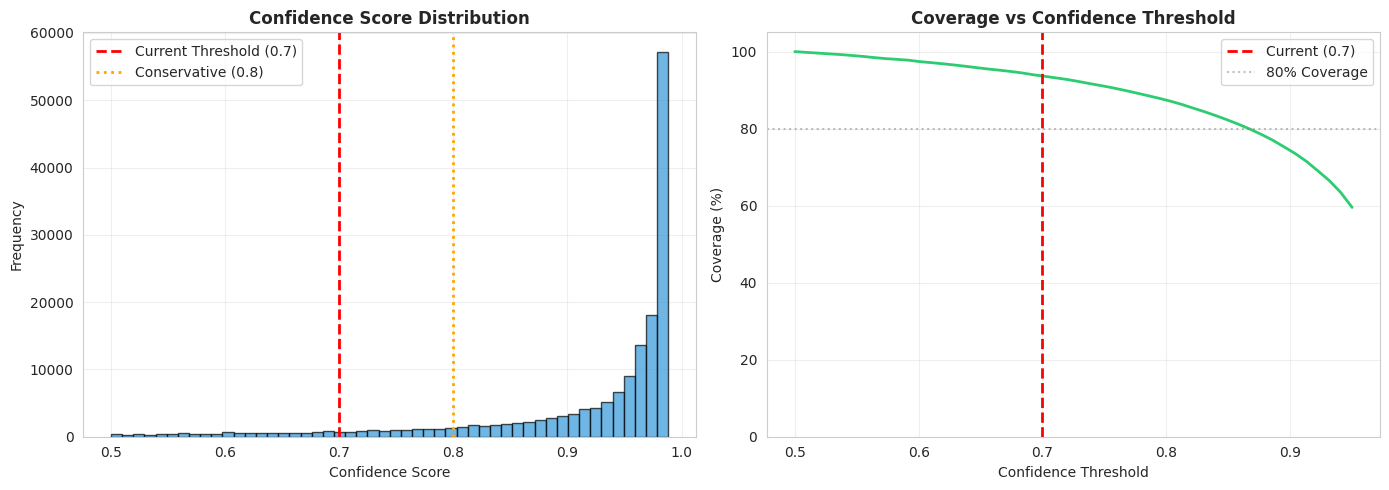


✓ Analysis saved to: /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/confidence_threshold_analysis.png


In [ ]:
# ==============================================================================
# Empirical Analysis: Confidence Threshold Trade-offs
# ==============================================================================

print("\n" + "=" * 70)
print("CONFIDENCE THRESHOLD ANALYSIS")
print("=" * 70)
print("\nAcademic References:")
print("  [1] Hendrycks & Gimpel (2017) - Baseline for Detecting Misclassified Examples")
print("  [2] Guo et al. (2017) - On Calibration of Modern Neural Networks")
print("  [3] Ratner et al. (2016) - Data Programming (Weak Supervision)")
print("=" * 70)

# Define threshold candidates
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

print(f"\n{'Threshold':<12} {'High Conf %':<15} {'Flagged %':<15} {'Mean Conf':<15} {'Interpretation'}")
print("-" * 90)

threshold_analysis = []

for thresh in thresholds:
    high_conf_mask = df_exploded['confidence'] >= thresh
    pct_high = (high_conf_mask.sum() / len(df_exploded)) * 100
    pct_flagged = 100 - pct_high
    mean_conf = df_exploded[high_conf_mask]['confidence'].mean() if high_conf_mask.sum() > 0 else 0

    # Interpretation based on literature
    if thresh <= 0.6:
        interpret = "Liberal (High Recall)"
    elif thresh <= 0.75:
        interpret = "Balanced (Recommended)"
    elif thresh <= 0.85:
        interpret = "Conservative"
    else:
        interpret = "Very Conservative"

    threshold_analysis.append({
        'threshold': thresh,
        'pct_high_conf': round(pct_high, 2),
        'pct_flagged': round(pct_flagged, 2),
        'mean_conf': round(mean_conf, 4),
        'interpretation': interpret
    })

    print(f"{thresh:<12.1f} {pct_high:<15.1f} {pct_flagged:<15.1f} {mean_conf:<15.4f} {interpret}")

print("=" * 70)

# Confidence distribution percentiles
print(f"\n  Confidence Score Percentiles:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(df_exploded['confidence'], p)
    print(f"    {p:>2}th percentile: {val:.4f}")

print("\n" + "=" * 70)
print("RECOMMENDATION (Based on Guo et al. 2017 & Weak Supervision Literature):")
print("=" * 70)
print(f"  Current Threshold: {CFG.confidence_threshold}")
print(f"  High Confidence:   {(df_exploded['confidence'] >= CFG.confidence_threshold).sum():,} predictions ({(df_exploded['confidence'] >= CFG.confidence_threshold).mean()*100:.1f}%)")
print(f"  Flagged for Review: {(df_exploded['confidence'] < CFG.confidence_threshold).sum():,} predictions ({(df_exploded['confidence'] < CFG.confidence_threshold).mean()*100:.1f}%)")
print(f"\n  ✓ For Power BI Dashboard: 0.7-0.8 provides good balance")
print(f"  ✓ For High-Stakes Decisions: Use ≥0.8 and manually review flagged cases")
print(f"  ✓ For Maximum Coverage: Use ≥0.6 but note increased noise risk")
print("=" * 70)

# Create confidence distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Confidence histogram with threshold line
ax1 = axes[0]
ax1.hist(df_exploded['confidence'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(CFG.confidence_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Current Threshold ({CFG.confidence_threshold})')
ax1.axvline(0.8, color='orange', linestyle=':', linewidth=2, label='Conservative (0.8)')
ax1.set_title('Confidence Score Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

# Right plot: Coverage vs Threshold trade-off
ax2 = axes[1]
thresh_range = np.linspace(0.5, 0.95, 50)
coverage = [(df_exploded['confidence'] >= t).mean() * 100 for t in thresh_range]
ax2.plot(thresh_range, coverage, linewidth=2, color='#2ecc71')
ax2.axvline(CFG.confidence_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Current ({CFG.confidence_threshold})')
ax2.axhline(80, color='gray', linestyle=':', alpha=0.5, label='80% Coverage')
ax2.set_title('Coverage vs Confidence Threshold', fontsize=12, fontweight='bold')
ax2.set_xlabel('Confidence Threshold')
ax2.set_ylabel('Coverage (%)')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.savefig(os.path.join(CFG.output_dir, 'confidence_threshold_analysis.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Analysis saved to: {os.path.join(CFG.output_dir, 'confidence_threshold_analysis.png')}")